## Метод простой итерации

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Вспомогательные функции:

In [2]:
def makeI(n):
    # возвращает единичную матрицу размера n*n
    
    I = []
    for i in range(n):
        k = np.zeros(n)
        k[i] = 1
        I.append(k)
    return np.array(I)


def matrix_and_column_product(A, b):
    # произведение квадратной матрицы и столбца
    
    n = b.shape[0]
    c = np.zeros(n)
    
    for i in range(n):
        for j in range(n):
            c[i] = c[i] +  A[i][j] * b[j] 
            
    return c

Основная функция для вычисления решения:

In [3]:
# A, b - система, tau - итерационный параметр, max_iter - максимальное число итераций,
# tol - параметр, задающий критерий остановки для нормы невязки
def solve_mpi(A, b, tau, max_iter, tol):
    A = np.array(A)
    b = np.array(b)
    n = A.shape[0]
    
    I = makeI(n)
    S = I - tau * A
      
    # наше будущее решение
    y = np.zeros(n)
    
    # Решение, полученное на предыдущем шаге
    # изначально зададим его так, чтобы оно сильно отличалось от у, чтобы не остановиться на 1-й итерации
    y_pred = y + 100
    
    # значения нормы невязки на каждой итерации
    eps = []
    
    current_tol = 100
    
    for i in range(max_iter):
        # продолжаем только если еще не достигли заданного значения нормы невязки
        if (current_tol >= tol):
            
            y_pred = y
            
            y = matrix_and_column_product(S, y) + tau * b
            
            # тут можно рассматривать как = x_k - x, где х - точное решение.
            # Но точное решение мы пока не знаем, поэтому, как на семинаре, рассмотрим
            # разницу между двумя последовательными решениями
            current_tol = np.linalg.norm(y - y_pred, 1)
            eps.append(current_tol)
        else:
            break

    return y, eps

Создаем произвольную матрицу $A = A^T > 0$

In [4]:
# размер матрицы
N = 8
A = np.random.uniform(-10, 10, (N, N))
b = np.random.uniform(-10, 10, N)

# Этот шаг поможет сделать матрицу положительно определенной
A = A @ np.transpose(A)

# делаем, чтобы A = A^T
for i in range(N):
    for j in range(i):
        A[i, j] = A[j, i]

In [5]:
positive = True

# A - положительно определенная
for i in range(1, N + 1):
    A_i = np.array(A[:i, :i])
    det_i = np.linalg.det(A_i)
    if (det_i <= 0):
        positive = False
        
if (positive):
    print("Матрица подходит")
else:
    print("Матрица не является положительно определенной! Введите другую матрицу!")

Матрица подходит


### Вычисление собственных чисел

**1. Вычисление с помощью готовой функции**

In [6]:
real_eigvals = np.linalg.eigvals(A)

**2. С помощью кругов Гершгорина**

Здесь мы пользуемся теоремой про круги Гершгорина.

Кроме того, можем воспользоваться тем, что по условию наша матрица действительная. 


In [7]:
%matplotlib inline
import matplotlib

In [8]:
r_circles = []
r = np.zeros(N)

for i in range(N):
    for j in range(N):
        if j!=i:
            r[i] += abs(A[i, j])

# рассматриваем круги
for i in range(N):
    
    # A - действительная -> мнимой части нет
    center = A[i, i]
    radius_r = r[i]
    
    # A - действительная -> "круги" представляют собой отрезки
    min_r = center - radius_r
    max_r = center + radius_r
    
    # добавляем границы кругов в массив
    r_circles.append(np.array([min_r, max_r]))    

Изобразим на графике то, что у нас получилось:

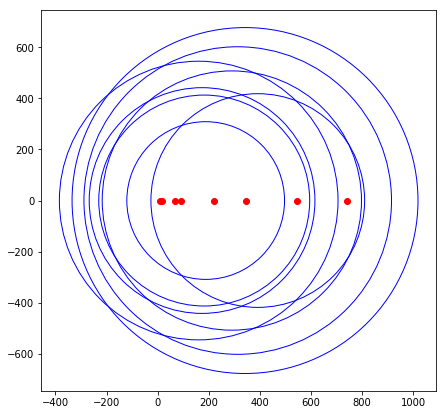

In [9]:
fig, ax = plt.subplots(figsize = (13, 7))
for i in range(N):
    center = (A[i, i], 0)
    ax.add_patch(matplotlib.patches.Circle(center, r[i], fill = False, color = 'blue'))
ax.plot(real_eigvals, np.zeros(N),'ro')
ax.set_aspect('equal')

Как мы видим, все собственные значения находятся в объединении кругов.

Таким образом, можем найти ограничение на спектр $A$ (учтем также, что А - действительная):

In [10]:
r_circles = np.array(r_circles)

g_lambda_min = r_circles[0, 0]
g_lambda_max = r_circles[0, 1]

for i in range(N):
    
    # минимум среди левых границ отрезков
    if (r_circles[i, 0] < g_lambda_min):
        g_lambda_min = r_circles[i, 0]
 
    # максимум среди правых границ отрезков
    if (r_circles[i, 1] > g_lambda_max):
        g_lambda_max = r_circles[i, 1]
        
print('Оценка минимального СЗ: ', g_lambda_min)
print('Оценка максимального СЗ: ', g_lambda_max)

print('Точное минимальное СЗ: ', np.min(real_eigvals))
print('Точное максимальное СЗ: ', np.max(real_eigvals))

Оценка минимального СЗ:  -384.7766912019212
Оценка максимального СЗ:  1019.3474962471059
Точное минимальное СЗ:  7.352448792785973
Точное максимальное СЗ:  742.9349749158466


### Вычисление приближенного решения

In [11]:
# a) Произвольное значениe из допустимой области: 0 < tau < 2/lambda_max
tau_1 = np.random.uniform(0, 2 / np.max(real_eigvals))
print('tau_1 = ', tau_1)

# b) Оптимальное значение, вычисленное по оценкам с.ч.
tau_2 = 2 / (max(g_lambda_min, 0) + g_lambda_max)
print('tau_2 = ', tau_2)

# c) Оптимальное значение, вычисленное по точным с.ч
tau_3 = 2 / (np.min(real_eigvals) + np.max(real_eigvals))
print('tau_3 = ', tau_3)

tau_1 =  0.0011686671746746254
tau_2 =  0.001962039449121449
tau_3 =  0.002665645107196522


Сравним нормы разницы между решениями:

In [12]:
# реальное решение
x_real = np.linalg.solve(A, b)
max_iter = 10000

# невязка
tol = 1e-6

x_1, eps_1 = solve_mpi(A, b, tau_1, max_iter, tol)
x_2, eps_2 = solve_mpi(A, b, tau_2, max_iter, tol)
x_3, eps_3 = solve_mpi(A, b, tau_3, max_iter, tol)

print('Приближенное решение 1: ', x_1)
print('Норма разницы 1: ', np.linalg.norm(x_real - x_1, 1))
print('-------------------------')
print('Приближенное решение 2: ', x_2)
print('Норма разницы 2: ', np.linalg.norm(x_real - x_2, 1))
print('-------------------------')
print('Приближенное решение 3: ', x_3)
print('Норма разницы 3: ', np.linalg.norm(x_real - x_3, 1))

Приближенное решение 1:  [ 0.24582193 -0.07835774 -0.27584954  0.05643246  0.06845905  0.09100695
 -0.17019486 -0.09679816]
Норма разницы 1:  0.0001149154602369945
-------------------------
Приближенное решение 2:  [ 0.24581961 -0.07835424 -0.27585366  0.0564353   0.06846948  0.09099068
 -0.17020126 -0.09679728]
Норма разницы 2:  6.817988031893735e-05
-------------------------
Приближенное решение 3:  [ 0.2458163  -0.07834936 -0.27585956  0.05643936  0.06848426  0.09096737
 -0.17021034 -0.09679594]
Норма разницы 3:  1.5838503846996033e-06


Как мы видим, во всех случаях норма не совсем одинаковая, лучше всего она в третьем случае, хуже - в первом, что неудивительно, поскольку в первом случае мы выбирали параметр случайно, в третьем же использовали оптимальный параметр.

При изменении параметра tol можно варьировать нашу точность. Например, если поставить в клетке выше tol = 1e-7, то норма будет уже порядка выше. 

Изобразим теперь графики зависимости логарифма нормы невязки от номера итерации:

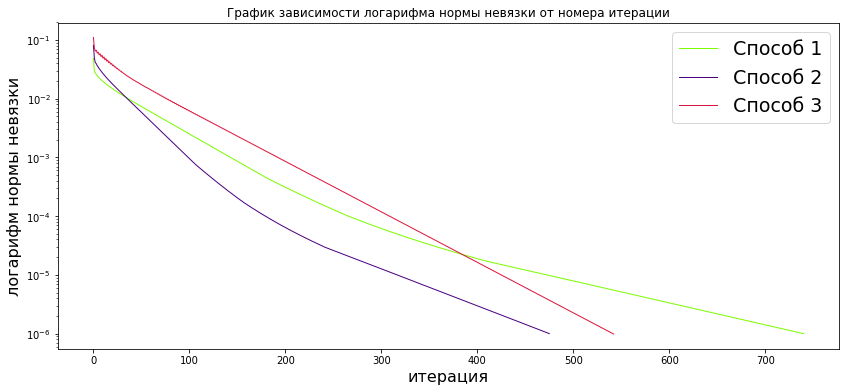

In [13]:
plt.figure(figsize=(14, 6))
nn = np.arange(0, max_iter)
plt.plot(eps_1, color='lawngreen', label="Способ 1", linewidth=1)
plt.plot(eps_2, color='indigo', label="Способ 2", linewidth=1)
plt.plot(eps_3, color='crimson', label="Способ 3", linewidth=1)
plt.yscale('log')
plt.xlabel('итерация', fontsize=16)
plt.ylabel('логарифм нормы невязки', fontsize=16)
plt.legend(fontsize=19)
plt.title("График зависимости логарифма нормы невязки от номера итерации")
plt.show()

Как можно заметить по графику, норма невязки (ее логарифм) с течением времени уменьшается быстрее всего в 3 случае, а медленнее всего в 1 случае. И снова, это вполне логично из тех соображений, что в 3 случае мы использовали оптимальный параметр, а в 1 - вообще случайный из допустимого интервала.